In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np; np.set_printoptions(precision=4); np.random.seed(0)
import torch; torch.set_printoptions(precision=4)
seed = 1

torch.manual_seed(seed)
import torch.nn as nn
import matplotlib.pyplot as plt; plt.rc('font', size=12)
import matplotlib 
from matplotlib.font_manager import FontProperties
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl
import seaborn as sns
import time
import sys
import itertools
import random; random.seed(0)
import scipy
import os
from textwrap import wrap
from scipy.stats import wilcoxon

sys.path.append("../two_module_rnn/code")
os.chdir('/home/yl4317/Documents/two_module_rnn/code')
from functions import *
# os.chdir('/home/yl4317/Documents/two_module_rnn/')

print(torch.__version__)
print(sys.version)
                
%matplotlib inline

torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True) 
torch.backends.cudnn.deterministic = True    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.13.1+cu116
3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]


# Supplementary figure 1: rule selectivity across epochs

success_2023-05-10-14-28-42_wcst_105_sparsity0
success_2023-05-10-14-28-42_wcst_106_sparsity0
success_2023-05-10-14-28-42_wcst_10_sparsity0
success_2023-05-10-14-28-42_wcst_112_sparsity0
success_2023-05-10-14-28-42_wcst_115_sparsity0
success_2023-05-10-14-28-42_wcst_116_sparsity0
success_2023-05-10-14-28-42_wcst_118_sparsity0
success_2023-05-10-14-28-42_wcst_121_sparsity0
success_2023-05-10-14-28-42_wcst_122_sparsity0
success_2023-05-10-14-28-42_wcst_124_sparsity0
success_2023-05-10-14-28-42_wcst_126_sparsity0
success_2023-05-10-14-28-42_wcst_131_sparsity0
success_2023-05-10-14-28-42_wcst_134_sparsity0
success_2023-05-10-14-28-42_wcst_136_sparsity0
success_2023-05-10-14-28-42_wcst_139_sparsity0
success_2023-05-10-14-28-42_wcst_142_sparsity0
success_2023-05-10-14-28-42_wcst_143_sparsity0
success_2023-05-10-14-28-42_wcst_144_sparsity0
success_2023-05-10-14-28-42_wcst_149_sparsity0
success_2023-05-10-14-28-42_wcst_150_sparsity0
success_2023-05-10-14-28-42_wcst_151_sparsity0
success_2023-0

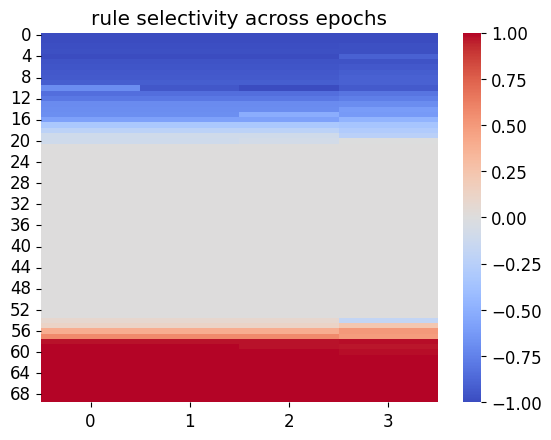

sr_edend
sr_pv


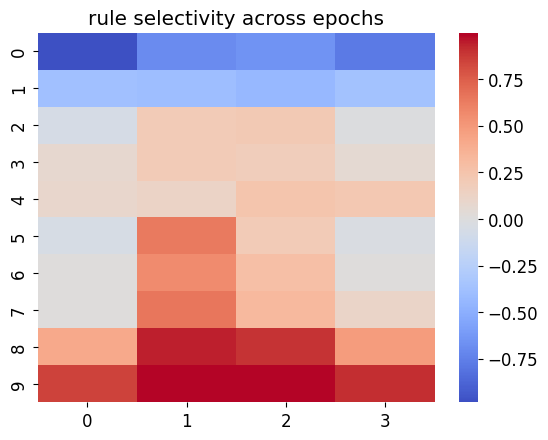

sr_sst


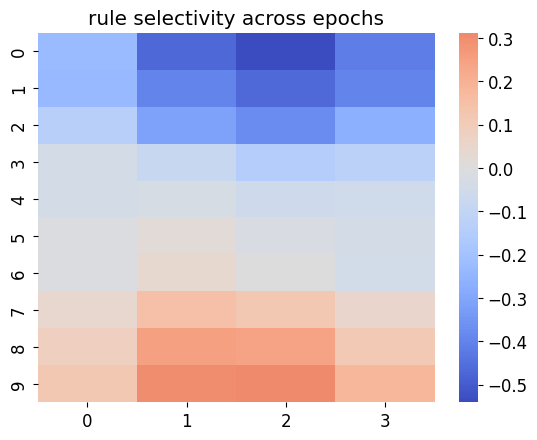

sr_vip


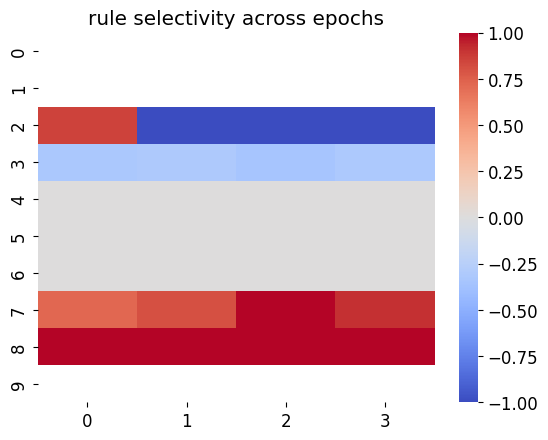

pfc_esoma


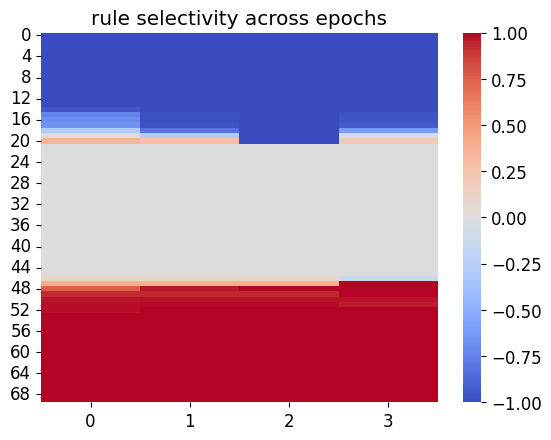

pfc_edend
pfc_pv


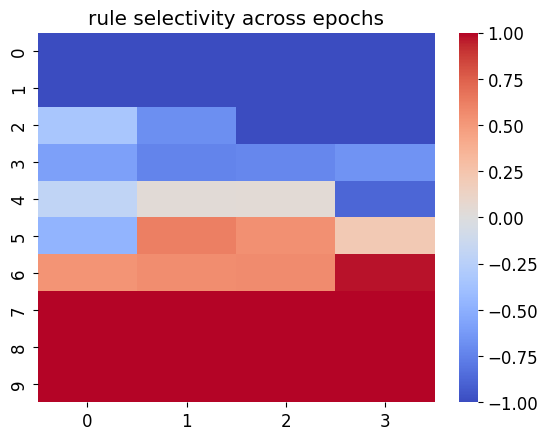

pfc_sst


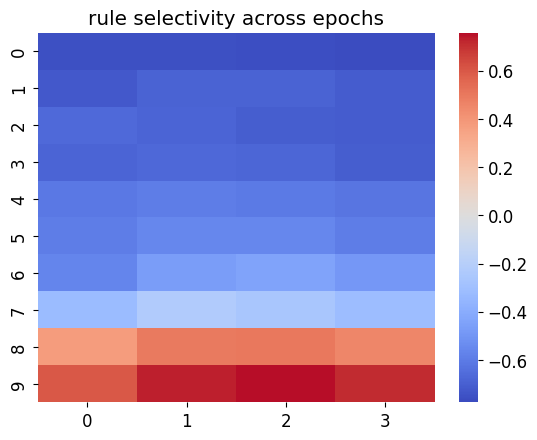

pfc_vip
success_2023-05-10-14-28-42_wcst_6_sparsity0
success_2023-05-10-14-28-42_wcst_7_sparsity0
success_2023-05-10-14-28-42_wcst_82_sparsity0
success_2023-05-10-14-28-42_wcst_86_sparsity0
success_2023-05-10-14-28-42_wcst_87_sparsity0
success_2023-05-10-14-28-42_wcst_93_sparsity0
success_2023-05-10-14-28-42_wcst_98_sparsity0


In [13]:
data_suppfig1_rule_sel_across_epochs = {}
for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
    if ('2023-05-10' in model_name) and 'wcst' in model_name and 'success' in model_name:
        if model_name != 'success_2023-05-10-14-28-42_wcst_63_sparsity0':    # this is the example model shown in the paper
            continue
        
        # load model
        print('loading model...')
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, simple=False, plot=False, toprint=False)
        
        # load data
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_noiseless_no_current_matrix'), 'rb') as f:
            neural_data = pickle.load(f)
        test_data = neural_data['test_data']
        mean_perf = np.mean([_[0] for _ in test_data['perfs']])
        mean_perf_rule = np.mean([_[0] for _ in test_data['perf_rules']])
        if mean_perf<0.8 or mean_perf_rule<0.8:
            print('low performing model ({}/{})'.format(mean_perf, mean_perf_rule))
            continue
        rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()
        
        # generate trial labels
        trial_labels = label_trials_wcst(test_data=test_data)
        rule1_trs_stable = trial_labels['rule1_trs_stable']
        rule2_trs_stable = trial_labels['rule2_trs_stable']
        rule1_trs_after_error = trial_labels['rule1_trs_after_error']
        rule2_trs_after_error = trial_labels['rule2_trs_after_error']
        c1_trs_stable = trial_labels['c1_trs_stable']
        c2_trs_stable = trial_labels['c2_trs_stable']
        c3_trs_stable = trial_labels['c3_trs_stable']
        resp_trs_stable = {'c1': c1_trs_stable, 'c2': c2_trs_stable, 'c3': c3_trs_stable}    # to be used as an argument in the "compute_sel_wcst" function
        error_trials = trial_labels['error_trials']
        
        # compute cell selectivity
        all_sels = compute_sel_wcst(rnn_activity=rnn_activity, hp=hp_test, hp_task=hp_task_test, rules=test_data['rules'], rule1_trs_stable=trial_labels['rule1_trs_stable'], rule2_trs_stable=trial_labels['rule2_trs_stable'], 
                                    rule1_trs_after_error = trial_labels['rule1_trs_after_error'], rule2_trs_after_error=trial_labels['rule2_trs_after_error'], resp_trs_stable = resp_trs_stable, 
                                    trs_by_center_card=trial_labels['trs_by_center_card_stable'], stims=test_data['stims'], error_trials=trial_labels['error_trials'], trial_labels=trial_labels)
        rule_sel_time = all_sels['rule_across_time']
        rule_sel_epoch = all_sels['rule_across_epochs']
        
        
        
        #======= ANALYSIS =======#
        for cg in model.rnn.cell_group_list:
            print(cg)
            if 'dend' in cg or cg == 'pfc_vip':
                continue
            # matrix_time = []
            # rule_sel_cg_dict = dict([(n, np.mean(rule_sel_time[n])) for n in model.rnn.cg_idx[cg]])
            # rule_sel_cg_dict_sorted = sorted(rule_sel_cg_dict.items(), key=lambda x:x[1])
            # neuron_idx_sorted = [_[0] for _ in rule_sel_cg_dict_sorted]
            # for n in neuron_idx_sorted:
            #     matrix_time.append(rule_sel_time[n])
            # fig, ax = plt.subplots()
            # ax.set_title('rule selectivity across time')
            # sns.heatmap(matrix_time, center=0, cmap='coolwarm')
            # plt.show()
    
            matrix_epochs = []
            rule_sel_cg_dict = dict([(n, np.mean(rule_sel_epoch[n])) for n in model.rnn.cg_idx[cg]])
            rule_sel_cg_dict_sorted = sorted(rule_sel_cg_dict.items(), key=lambda x:x[1])
            neuron_idx_sorted = [_[0] for _ in rule_sel_cg_dict_sorted]
            for n in neuron_idx_sorted:
                matrix_epochs.append(rule_sel_epoch[n])
            fig, ax = plt.subplots()
            ax.set_title('rule selectivity across epochs')
            sns.heatmap(matrix_epochs, center=0, cmap='coolwarm')
            plt.show()
            fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/rule_sel_across_epochs_{}.pdf'.format(cg))
    
            # matrix_epochs_binary = np.abs(np.array(matrix_epochs))>0.5
            # fig, ax = plt.subplots()
            # ax.set_title('rule selectivity across epochs (binary)')
            # sns.heatmap(matrix_epochs_binary, center=0, cmap='coolwarm')
            # plt.show()

            data_suppfig1_rule_sel_across_epochs[cg] = matrix_epochs

pd.DataFrame.from_dict(data=data_suppfig1_rule_sel_across_epochs, orient='index').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig1_rule_sel_across_epochs.csv', header=False)